In [5]:
import os
import sys
from pathlib import Path
import random
import math
import json

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

PROJECT_ROOT = Path("/kaggle/working/").resolve()
DATA_ROOT = Path("/kaggle/input/one-piece-classification-2025").resolve()
CHECKPOINT_DIR = PROJECT_ROOT / "artifacts" / "checkpoints"
LOG_DIR = PROJECT_ROOT / "artifacts" / "logs"
OUTPUT_DIR = PROJECT_ROOT / "artifacts"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using data from: {DATA_ROOT}")
print(f"Checkpoints: {CHECKPOINT_DIR}")


Using data from: /kaggle/input/one-piece-classification-2025
Checkpoints: /kaggle/working/artifacts/checkpoints


In [6]:
class CFG:
    num_classes = 18
    image_size = 224
    batch_size = 32
    num_workers = 4
    epochs = 20
    warmup_epochs = 2
    lr = 3e-4
    weight_decay = 1e-4
    label_smoothing = 0.05
    mixup_alpha = 0.2
    cutmix_alpha = 1.0
    dropout = 0.3
    val_size = 0.15
    random_state = 1337
    patience = 5
    max_grad_norm = 2.0
    log_interval = 25

    train_dir = DATA_ROOT / "splitted" / "train"
    test_dir = DATA_ROOT / "splitted" / "test"
    ann_path = DATA_ROOT / "train_annotations.csv"
    labels = json.loads((DATA_ROOT / "labels.json").read_text())
    id2label = {int(k): v for k, v in labels.items()}
    label2id = {v: k for k, v in id2label.items()}

CFG.id2label


{0: 'Ace',
 1: 'Akainu',
 2: 'Brook',
 3: 'Chopper',
 4: 'Crocodile',
 5: 'Franky',
 6: 'Jinbei',
 7: 'Kurohige',
 8: 'Law',
 9: 'Luffy',
 10: 'Mihawk',
 11: 'Nami',
 12: 'Rayleigh',
 13: 'Robin',
 14: 'Sanji',
 15: 'Shanks',
 16: 'Usopp',
 17: 'Zoro'}

In [7]:
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device


set_seed(CFG.random_state)
device = get_device()


Using device: cuda


In [8]:
class AnimeDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        image = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = int(row["label"])
        return image, label


def build_transforms():
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(CFG.image_size, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.6),
        transforms.RandomApply([transforms.RandomRotation(15)], p=0.5),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(int(CFG.image_size * 1.15)),
        transforms.CenterCrop(CFG.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_tf, eval_tf


def load_metadata():
    df = pd.read_csv(CFG.ann_path)
    df = df[df["split"] == "train"].copy()
    df["filepath"] = df.apply(
        lambda row: str(CFG.train_dir / row["class"] / row["image_name"]), axis=1
    )
    df["label"] = df["class"].map(CFG.label2id)
    return df


def stratified_split(df: pd.DataFrame):
    splitter = StratifiedShuffleSplit(
        n_splits=1, test_size=CFG.val_size, random_state=CFG.random_state
    )
    train_idx, val_idx = next(splitter.split(df["filepath"], df["label"]))
    return df.iloc[train_idx], df.iloc[val_idx]


def make_sampler(labels):
    counts = np.bincount(labels, minlength=CFG.num_classes)
    weights = 1.0 / (counts + 1e-6)
    sample_weights = torch.tensor([weights[label] for label in labels], dtype=torch.double)
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


def create_dataloaders():
    df = load_metadata()
    train_df, val_df = stratified_split(df)
    train_tf, eval_tf = build_transforms()
    train_ds = AnimeDataset(train_df, train_tf)
    val_ds = AnimeDataset(val_df, eval_tf)
    sampler = make_sampler(train_df["label"].tolist())

    train_loader = DataLoader(
        train_ds,
        batch_size=CFG.batch_size,
        sampler=sampler,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )
    return train_loader, val_loader, train_df, val_df



In [9]:
metadata = load_metadata()
print(f"Total images: {len(metadata)}")
metadata["class"].value_counts().sort_values(ascending=False).head()


Total images: 2916


class
Nami       181
Brook      178
Law        175
Usopp      170
Chopper    170
Name: count, dtype: int64

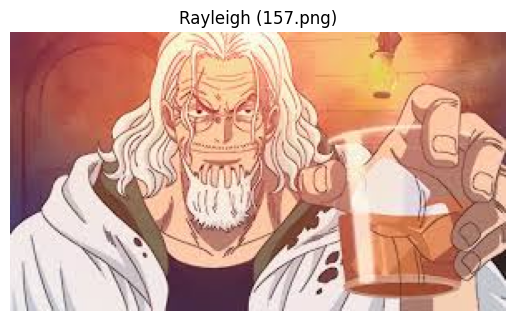

In [10]:
import matplotlib.pyplot as plt

sample_row = metadata.sample(1, random_state=CFG.random_state).iloc[0]
img = Image.open(sample_row["filepath"])
plt.imshow(img)
plt.axis("off")
plt.title(f"{sample_row['class']} ({sample_row['image_name']})")
plt.show()


In [11]:
def mixup(inputs, targets, alpha):
    if alpha <= 0:
        return inputs, targets, targets, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    index = torch.randperm(batch_size).to(inputs.device)
    mixed = lam * inputs + (1 - lam) * inputs[index]
    return mixed, targets, targets[index], lam


def cutmix(inputs, targets, alpha):
    if alpha <= 0:
        return inputs, targets, targets, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = inputs.size()
    index = torch.randperm(batch_size).to(inputs.device)
    cx, cy = np.random.randint(w), np.random.randint(h)
    cut_ratio = np.sqrt(1 - lam)
    half_w = int(w * cut_ratio / 2)
    half_h = int(h * cut_ratio / 2)
    x1 = np.clip(cx - half_w, 0, w)
    x2 = np.clip(cx + half_w, 0, w)
    y1 = np.clip(cy - half_h, 0, h)
    y2 = np.clip(cy + half_h, 0, h)
    inputs[:, :, y1:y2, x1:x2] = inputs[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))
    return inputs, targets, targets[index], lam



In [12]:
def create_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(CFG.dropout),
        nn.Linear(in_features, CFG.num_classes),
    )
    return model



In [13]:
def loss_with_aux(criterion, outputs, targets_a, targets_b, lam):
    return lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)


def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    progress = tqdm(loader, desc="Train", leave=False)
    for step, (images, labels) in enumerate(progress, start=1):
        images = images.to(device)
        labels = labels.to(device)
        if np.random.rand() < 0.5:
            images, targets_a, targets_b, lam = cutmix(images, labels, CFG.cutmix_alpha)
        else:
            images, targets_a, targets_b, lam = mixup(images, labels, CFG.mixup_alpha)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            outputs = model(images)
            if lam == 1.0:
                loss = criterion(outputs, labels)
            else:
                loss = loss_with_aux(criterion, outputs, targets_a, targets_b, lam)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        if step % CFG.log_interval == 0:
            progress.set_postfix(loss=running_loss / step)
    return running_loss / max(1, len(loader))


def evaluate(model, loader, criterion):
    model.eval()
    preds, targets = [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validate", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().tolist())
            targets.extend(labels.cpu().tolist())
    macro_f1 = f1_score(targets, preds, average="macro")
    report = classification_report(targets, preds, target_names=list(CFG.label2id.keys()), digits=4)
    (LOG_DIR / "classification_report.txt").write_text(report)
    return running_loss / max(1, len(loader)), macro_f1


In [14]:
train_loader, val_loader, train_df, val_df = create_dataloaders()
model = create_model().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

warmup_steps = CFG.warmup_epochs * len(train_loader)
total_steps = CFG.epochs * len(train_loader)
linear_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.2, total_iters=max(1, warmup_steps))
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_steps))
scheduler = optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[linear_scheduler, cosine_scheduler],
    milestones=[warmup_steps],
)

best_f1 = 0.0
patience_counter = 0
history = []

for epoch in range(1, CFG.epochs + 1):
    print(f"Epoch {epoch}/{CFG.epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_f1 = evaluate(model, val_loader, criterion)
    scheduler.step()
    history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_f1": val_f1})
    print(f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_f1:.4f}")
    torch.save({"model_state": model.state_dict()}, CHECKPOINT_DIR / "last_notebook.pt")
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save({"model_state": model.state_dict()}, CHECKPOINT_DIR / "best_notebook.pt")
        print("Saved new best checkpoint.")
    else:
        patience_counter += 1
        if patience_counter >= CFG.patience:
            print("Early stopping triggered.")
            break

print(f"Best macro F1: {best_f1:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]
/tmp/ipykernel_47/2102628321.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")


Epoch 1/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   6%|▋         | 5/77 [00:04<00:34,  2.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  23%|██▎       | 18/77 [00:06<00:11,  5.05it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  95%|█████████▍| 73/77 [00:18<00:00,  5.64it/s, loss=2.86]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=2.8204 val_loss=2.5938 val_f1=0.4180
Saved new best checkpoint.
Epoch 2/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   3%|▎         | 2/77 [00:01<00:38,  1.95it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  43%|████▎     | 33/77 [00:06<00:06,  6.77it/s, loss=2.6]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  65%|██████▍   | 50/77 [00:10<00:08,  3.13it/s, loss=2.51]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=2.3909 val_loss=1.6109 val_f1=0.6958
Saved new best checkpoint.
Epoch 3/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   5%|▌         | 4/77 [00:01<00:15,  4.71it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  10%|█         | 8/77 [00:02<00:13,  5.25it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  14%|█▍        | 11/77 [00:02<00:12,  5.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/I

train_loss=1.8274 val_loss=1.0281 val_f1=0.8266
Saved new best checkpoint.
Epoch 4/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  10%|█         | 8/77 [00:02<00:12,  5.50it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  17%|█▋        | 13/77 [00:03<00:13,  4.72it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  22%|██▏       | 17/77 [00:04<00:10,  5.91it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=1.5025 val_loss=0.8443 val_f1=0.8679
Saved new best checkpoint.
Epoch 5/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   5%|▌         | 4/77 [00:01<00:16,  4.50it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  13%|█▎        | 10/77 [00:02<00:12,  5.25it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  17%|█▋        | 13/77 [00:02<00:13,  4.87it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  39%|███▉      | 30/77 [00:06<00:09, 

train_loss=1.3762 val_loss=0.6878 val_f1=0.8998
Saved new best checkpoint.
Epoch 6/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  21%|██        | 16/77 [00:03<00:11,  5.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  71%|███████▏  | 55/77 [00:11<00:03,  5.54it/s, loss=1.29]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  74%|███████▍  | 57/77 [00:11<00:04,  4.15it/s, loss=1.29]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=1.2621 val_loss=0.6663 val_f1=0.9132
Saved new best checkpoint.
Epoch 7/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  73%|███████▎  | 56/77 [00:11<00:04,  4.95it/s, loss=1.16]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  92%|█████████▏| 71/77 [00:14<00:00,  6.04it/s, loss=1.16]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  94%|█████████▎| 72/77 [00:15<00:00,  6.47it/s, loss=1.16]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=1.1195 val_loss=0.6261 val_f1=0.9245
Saved new best checkpoint.
Epoch 8/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   3%|▎         | 2/77 [00:01<00:33,  2.22it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  23%|██▎       | 18/77 [00:04<00:10,  5.89it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  60%|█████▉    | 46/77 [00:10<00:05,  5.91it/s, loss=1.31]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  79%|███████▉  | 61/77 [00

train_loss=1.1556 val_loss=0.5912 val_f1=0.9423
Saved new best checkpoint.
Epoch 9/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  12%|█▏        | 9/77 [00:02<00:13,  5.03it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  14%|█▍        | 11/77 [00:02<00:10,  6.08it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=0.9679 val_loss=0.5661 val_f1=0.9274
Epoch 10/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   3%|▎         | 2/77 [00:01<00:44,  1.70it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  10%|█         | 8/77 [00:02<00:14,  4.65it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  64%|██████▎   | 49/77 [00:10<00:05,  5.34it/s, loss=0.991]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss=1.0112 val_loss=0.5589 val_f1=0.9352
Epoch 11/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:   5%|▌         | 4/77 [00:01<00:16,  4.50it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  31%|███       | 24/77 [00:05<00:09,  5.66it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  57%|█████▋    | 44/77 [00:09<00:05,  6.25it/s, loss=0.774]/usr/local/lib/python3.11/dist-p

train_loss=1.0253 val_loss=0.5734 val_f1=0.9343
Epoch 12/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  13%|█▎        | 10/77 [00:02<00:12,  5.43it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  17%|█▋        | 13/77 [00:03<00:12,  5.14it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  18%|█▊        | 14/77 [00:03<00:11,  5.68it/s]/usr/local/lib/python3.11/dist-packages/PIL

train_loss=1.0369 val_loss=0.5664 val_f1=0.9406
Epoch 13/20


Train:   0%|          | 0/77 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_47/3362080921.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
Train:  19%|█▉        | 15/77 [00:03<00:11,  5.57it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  44%|████▍     | 34/77 [00:07<00:08,  5.30it/s, loss=0.859]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  53%|█████▎    | 41/77 [00:08<00:08,  4.05it/s, loss=0.859]/usr/local/lib/pyth

train_loss=0.8924 val_loss=0.5461 val_f1=0.9402
Early stopping triggered.
Best macro F1: 0.9423


In [15]:
history_df = pd.DataFrame(history)
history_df

,epoch,train_loss,val_loss,val_f1
0,1,2.820392,2.593802,0.418007
1,2,2.390872,1.610888,0.695834
2,3,1.827427,1.028122,0.826583
3,4,1.502465,0.844295,0.867949
4,5,1.376246,0.687790,0.899764
5,6,1.262119,0.666306,0.913234
6,7,1.119505,0.626106,0.924489
7,8,1.155637,0.591208,0.942270
8,9,0.967923,0.566067,0.927379
9,10,1.011173,0.558906,0.935170


In [16]:
class AnimeTestDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = list(paths)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")
        return self.transform(image), path.name


def create_test_loader():
    _, eval_tf = build_transforms()
    test_paths = sorted(CFG.test_dir.glob("*"))
    dataset = AnimeTestDataset(test_paths, eval_tf)
    return DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )


In [20]:
def load_checkpoint(model, path):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state["model_state"])
    print(f"Loaded weights from {path}")


def run_inference(model_path=CHECKPOINT_DIR / "best_notebook.pt", submission_path=PROJECT_ROOT / "submission_from_notebook.csv"):
    model = create_model().to(device)
    load_checkpoint(model, model_path)
    model.eval()
    loader = create_test_loader()
    ids, preds = [], []
    with torch.no_grad():
        for images, names in tqdm(loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)
            ids.extend(names)
            preds.extend(outputs.argmax(dim=1).cpu().tolist())
    df = pd.DataFrame({"id": [id_i.split(".")[0] for id_i in ids], "label": preds})
    df.to_csv(submission_path, index=False)
    print(f"Saved submission to {submission_path}")


run_inference()


Loaded weights from /kaggle/working/artifacts/checkpoints/best_notebook.pt


Inference:   0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Inference:  41%|████      | 11/27 [00:02<00:02,  6.18it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Inference:  48%|████▊     | 13/27 [00:02<00:02,  6.70it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Inference: 100%|██████████| 27/27 [00:04<00:00,  5.88it/s]


Saved submission to /kaggle/working/submission_from_notebook.csv


In [21]:
print((LOG_DIR / "classification_report.txt").read_text())


              precision    recall  f1-score   support

         Ace     0.9167    0.8800    0.8980        25
      Akainu     0.9583    0.9200    0.9388        25
       Brook     0.9630    0.9630    0.9630        27
     Chopper     1.0000    0.9615    0.9804        26
   Crocodile     0.9615    1.0000    0.9804        25
      Franky     1.0000    0.7600    0.8636        25
      Jinbei     1.0000    1.0000    1.0000        25
    Kurohige     0.9545    0.8077    0.8750        26
         Law     0.8966    1.0000    0.9455        26
       Luffy     0.8750    0.9333    0.9032        15
      Mihawk     0.8800    0.8800    0.8800        25
        Nami     0.9630    0.9630    0.9630        27
    Rayleigh     1.0000    1.0000    1.0000        25
       Robin     1.0000    0.9600    0.9796        25
       Sanji     0.9524    1.0000    0.9756        20
      Shanks     0.8621    1.0000    0.9259        25
       Usopp     0.8065    0.9615    0.8772        26
        Zoro     1.0000    